# Multiple-objective portfolio optimization

# INTRODUCTION

Your task is to solve a multiple-objective portfolio optimization problem.
-  Use the basic Markowitz's model from 1952 (see Lecture 1)
-  Solve = construct Pareto front approximations.
-  The dataset is the same as for the portfolio game part 1 (bundle1.zip).
-  The dataset consists of the historical prices of 20 assets.
-  The bundle contains 20 files (*.txt) linked to different assets.
-  The name of the file suggests the asset's name.
-  The structure of every file is as follows:
1.  The first line contains the name of the asset.
2. The second line provides the number of data points N.
3. The following N lines are data points with the structure: time, price.
-  The historical timeline for all assets is time $\in$ [0,100].
-  Future predictions should be calculated for time = 200.

Goal: 
-  Load data, make predictions, and build the model. 
-  Illustrate your predictions (can be done in the jupyter notebook)
-  Then, implement the WSM and ECM methods (see the tutorial on quadratic programming provided below). 
-  Run your implementations for different calculation limits (e.g., the number of weight vectors for WSM). Compare the methods' efficiency in finding unique Pareto optimal solutions. Finally, illustrate generated Pareto fronts.

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cvxopt import matrix, solvers
from sklearn.linear_model import LinearRegression
import cvxopt

cvxopt.solvers.options["show_progress"] = False

# Short tutorial on the cvxopt library for quadratic programming

# QP Optimization Problem

### General model:

$max$ $\boldsymbol{cx} - \dfrac{1}{2}\boldsymbol{x}^T\boldsymbol{Qx}$ <br>
$s.t.$ <br>
$\boldsymbol{Gx} \leq \boldsymbol{h}$ <br>
$\boldsymbol{x} \geq \boldsymbol{0}$

### But the library uses the following form:

$min$ $\boldsymbol{cx} + \dfrac{1}{2}\boldsymbol{x}^T\boldsymbol{Qx}$ <br>
$s.t.$ <br>
$\boldsymbol{Gx} \leq \boldsymbol{h}$ <br>
$\boldsymbol{Ax} = \boldsymbol{b}$ <br>

### Exmple

$min$ $2x^2_1+x_2^2+x_1x_2+x_1+x_2$ <br>
$s.t.$ <br>
$x_1 \geq 0$<br>
$x_2 \geq 0$<br>
$x_1 + x_2 = 1$<br>

### Hence:

In [3]:
Q = matrix([[4.0, 1.0], [1.0, 2.0]])  ## [4, 1] is 1st column, not row!

In [4]:
c = matrix([1.0, 1.0])  ### (1, 2) = dimensions (1 row and 2 columns)

In [5]:
A = matrix([1.0, 1.0], (1, 2))  ### (1, 2) = dimensions (1 row and 2 columns)

In [6]:
b = matrix(1.0)

In [7]:
solQP = solvers.qp(Q, c, A, b)

In [8]:
print(solQP.keys())

dict_keys(['x', 'y', 's', 'z', 'status', 'gap', 'relative gap', 'primal objective', 'dual objective', 'primal infeasibility', 'dual infeasibility', 'primal slack', 'dual slack', 'iterations'])


In [9]:
print(solQP["x"])
print(solQP["primal objective"])

[-1.43e-01]
[-4.29e-01]

-0.2857142857142836


# We can also solve LP problems:

$min$ $\boldsymbol{c}\boldsymbol{x}$ <br>
$s.t.$ <br>
$\boldsymbol{Gx} \leq \boldsymbol{h}$ <br>
$\boldsymbol{Ax} = \boldsymbol{b}$ (optional)

### Exmple

$min$ $2x_1+x_2$ <br>
$s.t.$ <br>
$-x_1 +x_2 \leq 1$ <br>
$x_1 + x_2 \geq 2$ <br>
$x_2 \geq 0$<br>
$x_1 - 2x_2 \leq 4$

In [10]:
G = matrix([[-1.0, -1.0, 0.0, 1.0], [1.0, -1.0, -1.0, -2.0]])
h = matrix([1.0, -2.0, 0.0, 4.0])
c = matrix([2.0, 1.0])
solLP = solvers.lp(c, G, h)
###!!!! OPTIONALLY A and b can be provided (equality constraints) as in solQP=solvers.qp(Q, c, G, h, A, b)

In [11]:
print(solLP.keys())

dict_keys(['x', 'y', 's', 'z', 'status', 'gap', 'relative gap', 'primal objective', 'dual objective', 'primal infeasibility', 'dual infeasibility', 'primal slack', 'dual slack', 'residual as primal infeasibility certificate', 'residual as dual infeasibility certificate', 'iterations'])


In [12]:
print(solLP["x"])
print(solLP["primal objective"])

[ 5.00e-01]
[ 1.50e+00]

2.499999989554308


# Portfolio optimization

## Prepare the data

In [13]:

!mkdir -p data
!unzip Bundle1.zip -d data

unzip:  cannot find or open Bundle1.zip, Bundle1.zip.zip or Bundle1.zip.ZIP.


## Reading the files

In [14]:
NUM_ASSETS = 20


# Function to read asset data from a text file
def read_asset_data(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()

        asset_name = lines[0].strip()
        num_points = int(lines[1].strip())
        data = [float(line.split()[1]) for line in lines[2 : num_points + 2]]

    return asset_name, data


# Read all asset data
asset_data = {}
for file in pathlib.Path("data").glob("*.txt"):
    asset_name, data = read_asset_data(file)
    asset_data[asset_name] = data
asset_data = pd.DataFrame(asset_data)

assert len(asset_data.columns) == NUM_ASSETS

## Expected returns - linear regression

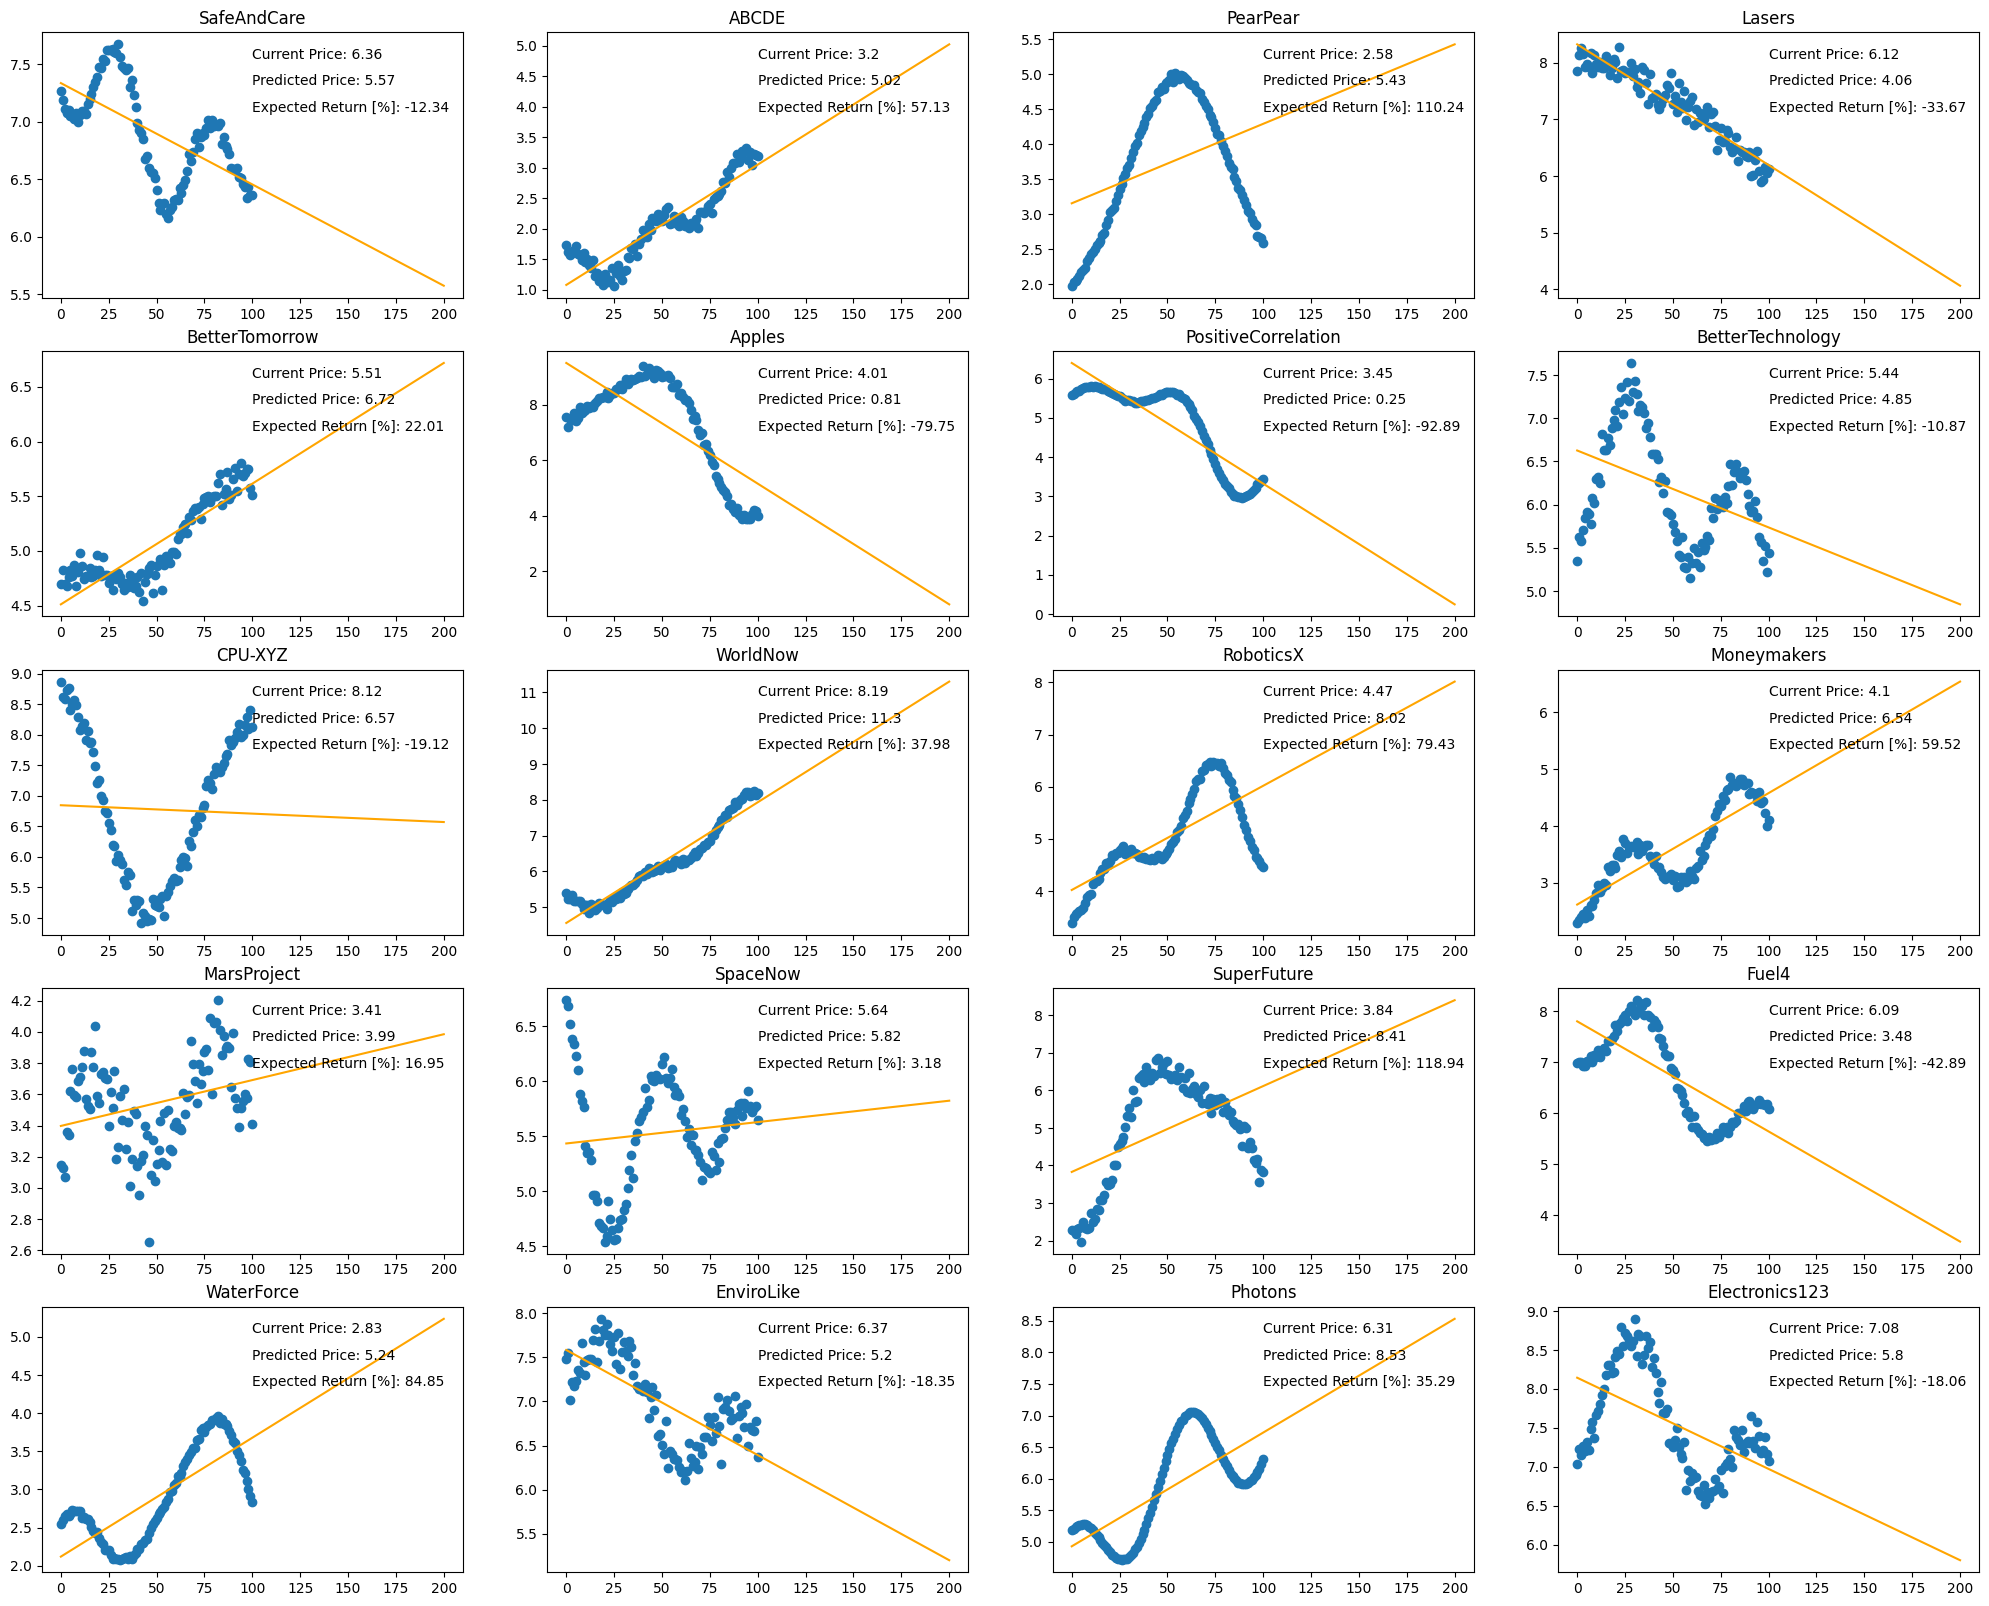

In [15]:
fig, axs = plt.subplots(5, 4, figsize=(25, 20))
predicted_returns = np.zeros(NUM_ASSETS)
for i, asset in enumerate(asset_data.columns):
    ax = axs.flat[i]
    ax.set_title(asset)

    data = asset_data[asset].values
    model = LinearRegression()
    model.fit(np.arange(0, 101).reshape(-1, 1), data)

    # stock_mean, stock_std = np.mean(data), np.std(data)
    predictions = model.predict(np.arange(0, 201).reshape(-1, 1))

    ax.scatter(np.arange(0, 101), asset_data[asset])
    ax.plot(np.arange(0, 201), predictions, color="orange")

    cur = data[100]
    pred = predictions[200]
    ret = (pred - cur) / cur * 100
    # print(i)
    predicted_returns[i] = ret
    ax.text(0.5, 0.9, f"Current Price: {np.round(cur, 2)}", transform=ax.transAxes)
    ax.text(0.5, 0.8, f"Predicted Price: {np.round(pred, 2)}", transform=ax.transAxes)
    ax.text(
        0.5, 0.7, f"Expected Return [%]: {np.round(ret, 2)}", transform=ax.transAxes
    )
    # ax.text(0.5, 0.6, f'Stock mean value: {np.round(stock_mean, 2)}', transform=ax.transAxes)
    # ax.text(0.5, 0.5, f'Stock moving std (risk): {np.round(stock_std, 2)}', transform=ax.transAxes)


In [16]:
asset_data.cov()

,SafeAndCare,ABCDE,PearPear,Lasers,BetterTomorrow,Apples,PositiveCorrelation,BetterTechnology,CPU-XYZ,WorldNow,RoboticsX,Moneymakers,MarsProject,SpaceNow,SuperFuture,Fuel4,WaterForce,EnviroLike,Photons,Electronics123
SafeAndCare,0.175232,-0.183971,-0.168245,0.157525,-0.069161,0.202389,0.133145,0.229615,0.079495,-0.254120,-0.102710,-0.026899,0.016614,-0.129568,-0.216068,0.254854,-0.125186,0.177487,-0.275011,0.203498
ABCDE,-0.183971,0.403613,0.082508,-0.382444,0.197417,-0.894318,-0.567603,-0.218674,0.127324,0.632071,0.235560,0.302164,0.037984,0.133655,0.239188,-0.384976,0.283588,-0.206808,0.298947,-0.240071
PearPear,-0.168245,0.082508,0.884963,-0.114002,-0.011171,0.619908,0.069168,-0.119229,-1.013762,0.140304,0.465661,0.063314,-0.077151,0.024280,1.270300,-0.212978,0.062465,-0.279232,0.452553,-0.145679
Lasers,0.157525,-0.382444,-0.114002,0.431069,-0.214224,0.927327,0.612798,0.170912,-0.097038,-0.650196,-0.323145,-0.370008,-0.062089,-0.056184,-0.298477,0.396426,-0.298974,0.200404,-0.299102,0.219345
BetterTomorrow,-0.069161,0.197417,-0.011171,-0.214224,0.137526,-0.597618,-0.359765,-0.088879,0.170741,0.342609,0.187273,0.210711,0.056968,0.009206,0.035503,-0.249388,0.195250,-0.093914,0.152333,-0.136330
Apples,0.202389,-0.894318,0.619908,0.927327,-0.597618,3.160575,1.725633,0.302672,-1.393334,-1.523879,-0.495779,-0.943218,-0.285765,-0.087916,0.582793,0.925440,-0.823955,0.240262,-0.348133,0.483345
PositiveCorrelation,0.133145,-0.567603,0.069168,0.612798,-0.359765,1.725633,1.074367,0.138953,-0.465960,-0.988165,-0.486623,-0.660395,-0.156168,-0.021188,-0.145229,0.570054,-0.508762,0.203761,-0.300121,0.275007
BetterTechnology,0.229615,-0.218674,-0.119229,0.170912,-0.088879,0.302672,0.138953,0.399461,-0.066274,-0.282308,-0.094917,0.042990,0.019304,-0.221355,-0.073457,0.408740,-0.193035,0.245174,-0.390584,0.362422
CPU-XYZ,0.079495,0.127324,-1.013762,-0.097038,0.170741,-1.393334,-0.465960,-0.066274,1.446062,0.196694,-0.258346,0.115281,0.169367,0.021136,-1.488363,-0.186209,0.237909,0.160250,-0.237018,-0.123045
WorldNow,-0.254120,0.632071,0.140304,-0.650196,0.342609,-1.523879,-0.988165,-0.282308,0.196694,1.055683,0.464932,0.578405,0.088760,0.128429,0.432536,-0.617371,0.469625,-0.317261,0.457647,-0.345985


In [17]:
cov_matrix = asset_data.cov().values

In [22]:
np.savetxt('predicted_returns.csv', np.round(predicted_returns, 5), delimiter=',')
np.savetxt('cov_matrix.csv', np.round(cov_matrix, 5), delimiter=',')

<!-- We don't need to check if weights are less then 1, because two above constraints are enough to ensure that. -->

In [31]:
random_profit_risk = pd.read_csv('output.csv',header=None)

In [37]:
random_profit = random_profit_risk[0]
random_risk = random_profit_risk[1]


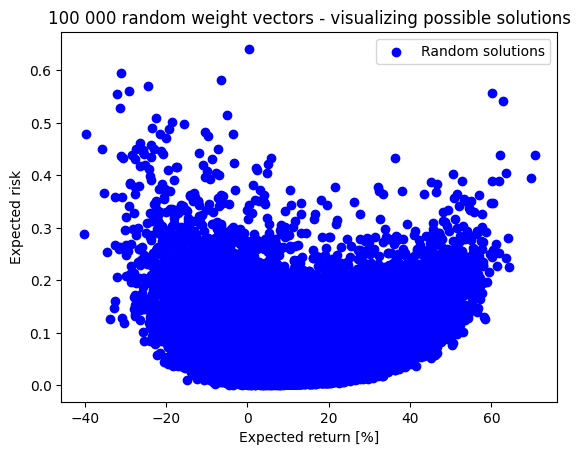

In [39]:
plt.scatter(random_profit, random_risk, color="blue", label="Random solutions")
plt.legend()
plt.title("100 000 random weight vectors - visualizing possible solutions")
plt.xlabel("Expected return [%]")
plt.ylabel("Expected risk")
plt.show()

# Weighted sum method
## Normalization


### 1. Find extreme solutions by minimizing objectives individually

#### 1.1 Minimazing *only* risk 

In [40]:
Q = matrix(cov_matrix)
c = matrix(np.zeros(NUM_ASSETS))
G = matrix(
    np.vstack(
        [
            -np.identity(NUM_ASSETS),
            np.identity(NUM_ASSETS),
        ]
    )
)
h = matrix(
    np.concat(
        [
            np.zeros(NUM_ASSETS),
            np.ones(NUM_ASSETS),
        ]
    )
)
A = matrix(np.ones(NUM_ASSETS), (1, NUM_ASSETS))
b = matrix(1.0)
sol = solvers.qp(Q, c, G, h, A, b)
weights = sol["x"]
smallest_risk = 0
profit = 0
for i in range(NUM_ASSETS):
    profit += weights[i] * predicted_returns[i]
    for j in range(NUM_ASSETS):
        smallest_risk += weights[i] * weights[j] * cov_matrix[i][j]
print(f"Profit {np.round(profit, 5)}")
print(f"Smallest risk {np.round(smallest_risk, 5)}")
print(sol["primal objective"])


Profit -2.237
Smallest risk 0.00018
8.818999012255859e-05


#### 1.2 Maximazing *only* profit

In [41]:
Q = matrix(np.zeros_like(cov_matrix))
c = matrix(-predicted_returns)
sol = solvers.qp(Q, c, G, h, A, b)
weights = sol["x"]
biggest_profit = 0
risk = 0
for i in range(NUM_ASSETS):
    biggest_profit += weights[i] * predicted_returns[i]
    for j in range(NUM_ASSETS):
        risk += weights[i] * weights[j] * cov_matrix[i][j]
print(f"Biggest profit {np.round(biggest_profit, 5)}")
print(f"Risk {np.round(risk, 5)}")
print(sol["primal objective"])


Biggest profit 118.93925
Risk 2.03338
-118.93924591079403


### Extreme solutions
- for min $-f_{return}$: [$-f_{return}$ = -118.93925 , $-f_{risk}$ = 2.03338 ]
- for min $-f_{risk}$: [$-f_{return}$ = 2.237 , $-f_{risk}$ = 0.00018 ]


### Pareto front
- for min $-f_{return}$: [-118.93925, 2.237]
- for min $-f_{risk}$: [0.00018, 2.03338]

### Normalization
$$\min w^*_{return}(-f_{return}(x)) + w^*_{risk}f_{risk}(x) \rightarrow 
	\frac{w^*_{return}(-f_{return}(x)-(-118.93925))}{2.237-(-118.93925)} + \frac{w^*_{risk}f_{risk}(x)-0.00018}{2.03338-0.00018}
$$

Shortcut:
- $ \frac{w^*_{return}(-f_{return}(x))}{121.17625} + const$
- $ \frac{w^*_{risk}f_{risk}(x)}{2.0332} + const$


In [42]:
NORM_RETURN = 121.17625
NORM_RISK = 2.0332

# Weighted Sum method


What we want from each of the matrices:
- Q: quadratic terms (covariances, "Risk", $\sigma$)

	$Q = w_1 * \sum_{i=0}^n \sum_{j=0}^n w_i w_j \sigma_{ij}$


- c: linear terms (regression resutls, expected profits, $p$) -> Negative because the library automatically minimizes
	
	$c = w_2 * -\sum_{i=0}^n w_i*p_i$

$s.t.$ <br>
$\boldsymbol{Gx} \leq \boldsymbol{h}$ <br>
$\boldsymbol{Ax} = \boldsymbol{b}$ <br>

G: inequality constraints coefficients
h: inequality constraints bounds

Our constraints are: $w_i \in [0,1] \text{ for i = 1, ..., n}$

Library only checks for $\leq$, therefore we need to:
- $-w_i \leq 0 $ ($w_i \geq 0$) AND $w_i \leq 1 $

- $$G = \begin{bmatrix}	-1 	& 0 	& ... 	& 0 	& 0 	\\ 
					0 	& -1 	& 0 	& ... 	& 0 	\\
					... & ... 	& ... 	& ... 	& ... 	\\
					0	& 0		& ... 	& -1	& 0		\\
					0	& 0		& ... 	& 0		& -1	\\
					-	& -		& - 	& -		& -		\\
					1 	& 0 	& ... 	& 0 	& 0 	\\ 
					0 	& 1 	& 0 	& ... 	& 0 	\\
					... & ... 	& ... 	& ... 	& ... 	\\
					0	& 0		& ... 	& 1		& 0		\\
					0	& 0		& ... 	& 0		& 1		\\
					\end{bmatrix}$$

- $$h = \begin{bmatrix} 0 	\\\ 
						0 	\\\
						... \\\
						0 	\\\
						0 	\\\
						-	\\\
						1 	\\\ 
						1 	\\\
						...	\\\
						1 	\\\
						1\end{bmatrix}$$


A: equality constraints coefficients
b: equality constraints bound

Our constraints are $\sum_{i=0}^n w_i = 1$
Therefore
- $A = [1, 1, ... 1, 1]$
- $b = 1$

In [43]:
G = matrix(
    np.vstack(
        [
            -np.identity(NUM_ASSETS),
            np.identity(NUM_ASSETS),
        ]
    )
)
h = matrix(
    np.concat(
        [
            np.zeros(NUM_ASSETS),
            np.ones(NUM_ASSETS),
        ]
    )
)

In [44]:
A = matrix(np.ones(NUM_ASSETS), (1, NUM_ASSETS))
b = matrix(1.0)

In [57]:
found_risk = []
found_returns = []
W1 = np.linspace(0, 1, 1000)  ### Objectives
W2 = 1 - W1
for w1, w2 in zip(W1, W2):
    Q = matrix(w1 * asset_data.cov().values / NORM_RISK)
    c = matrix(-w2 * predicted_returns / NORM_RETURN)
    # print(f'Risk weight: {w1}, returns weight: {w2}')
    sol = solvers.qp(Q, c, G, h, A, b, show_progress=False)

    optimal_x = sol["x"]
    total_returns = 0
    total_risk = 0
    for wi in range(NUM_ASSETS):
        # print(optimal_x[wi])
        # print(optimal_x[a]*predicted_returns[a])
        total_returns += optimal_x[wi] * predicted_returns[wi]
        for wj in range(NUM_ASSETS):
            total_risk += optimal_x[wi] * optimal_x[wj] * cov_matrix[wi][wj]
    # print(f'Primal Objective: {sol['primal objective']}')
    # print(f'Total profit: {total_returns}')
    # print(f'Total risk: {total_risk}')
    found_risk.append(total_risk)
    found_returns.append(total_returns)
    # break

In [58]:
unnormalized_found_risk = []
unnormalized_found_returns = []
W1 = np.linspace(0, 1, 1000)  ### Objectives
W2 = 1 - W1
for w1, w2 in zip(W1, W2):
    Q = matrix(w1 * asset_data.cov().values)
    c = matrix(-w2 * predicted_returns)
    # print(f'Risk weight: {w1}, returns weight: {w2}')
    sol = solvers.qp(Q, c, G, h, A, b, show_progress=False)

    optimal_x = sol["x"]
    total_returns = 0
    total_risk = 0
    for wi in range(NUM_ASSETS):
        # print(optimal_x[wi])
        # print(optimal_x[a]*predicted_returns[a])
        total_returns += optimal_x[wi] * predicted_returns[wi]
        for wj in range(NUM_ASSETS):
            total_risk += optimal_x[wi] * optimal_x[wj] * cov_matrix[wi][wj]
    # print(f'Primal Objective: {sol['primal objective']}')
    # print(f'Total profit: {total_returns}')
    # print(f'Total risk: {total_risk}')
    unnormalized_found_risk.append(total_risk)
    unnormalized_found_returns.append(total_returns)
    # break

1000 1000


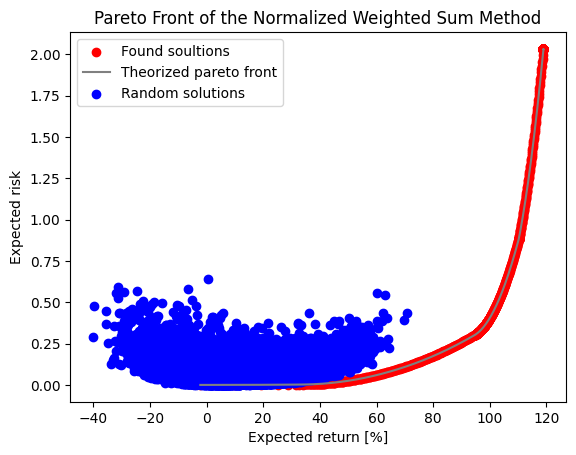

In [59]:
pairs = [(i, j) for i, j in zip(found_returns, found_risk)]
print(len(pairs), len(set(pairs)))
plt.scatter(found_returns, found_risk, color="red", label="Found soultions")
plt.plot(found_returns, found_risk, color="gray", label="Theorized pareto front")
plt.scatter(random_profit, random_risk, color="blue", label="Random solutions")
plt.legend()
plt.title("Pareto Front of the Normalized Weighted Sum Method")
plt.xlabel("Expected return [%]")
plt.ylabel("Expected risk")
plt.show()

1000 1000


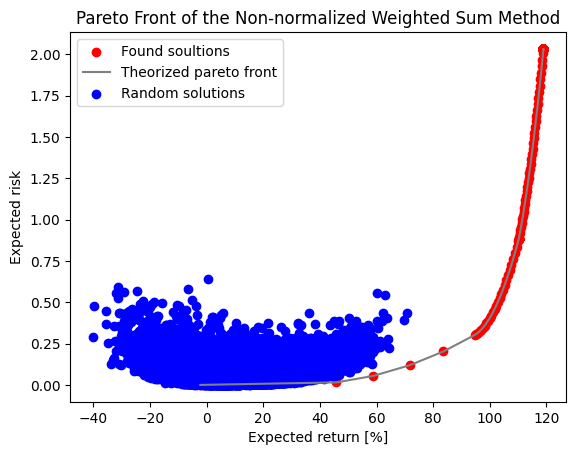

In [60]:
pairs = [(i, j) for i, j in zip(unnormalized_found_returns, unnormalized_found_risk)]
print(len(pairs), len(set(pairs)))
plt.scatter(
    unnormalized_found_returns,
    unnormalized_found_risk,
    color="red",
    label="Found soultions",
)
plt.plot(
    unnormalized_found_returns,
    unnormalized_found_risk,
    color="gray",
    label="Theorized pareto front",
)
plt.scatter(random_profit, random_risk, color="blue", label="Random solutions")

plt.legend()
plt.title("Pareto Front of the Non-normalized Weighted Sum Method")
plt.xlabel("Expected return [%]")
plt.ylabel("Expected risk")
plt.show()

# Epsilon-constrained method

What we want from each of the matrices:
- Q: quadratic terms (covariances, "Risk", $\sigma$)

	$Q = w_1 * \sum_{i=0}^n \sum_{j=0}^n w_i w_j \sigma_{ij}$


- c: linear terms (regression resutls, expected profits, $p$) -> Negative because the library automatically minimizes. In Epsilon-constrainded method empty!

$s.t.$ <br>
$\boldsymbol{Gx} \leq \boldsymbol{h}$ <br>
$\boldsymbol{Ax} = \boldsymbol{b}$ <br>

G: inequality constraints coefficients
h: inequality constraints bounds

Our constraints are: $w_i \in [0,1] \text{ for i = 1, ..., n}$

Additionally, $\sum{i=0}^n w_i r_i \geq \lambda \text{ (return threshold)}$ 

$\lambda$ is a hyperparameter dependant on our possible return ranges.


Library only checks for $\leq$, therefore we need to:
- $-w_i \leq 0 $ ($w_i \geq 0$) AND $w_i \leq 1 $
- $\sum_{i=0}^n -w_ir_i \leq \lambda $


- $$G = \begin{bmatrix}	-1 	& 0 	& ... 	& 0 	& 0 	\\ 
					0 	& -1 	& 0 	& ... 	& 0 	\\
					... & ... 	& ... 	& ... 	& ... 	\\
					0	& 0		& ... 	& -1	& 0		\\
					0	& 0		& ... 	& 0		& -1	\\
					-	& -		& - 	& -		& -		\\
					1 	& 0 	& ... 	& 0 	& 0 	\\ 
					0 	& 1 	& 0 	& ... 	& 0 	\\
					... & ... 	& ... 	& ... 	& ... 	\\
					0	& 0		& ... 	& 1		& 0		\\
					0	& 0		& ... 	& 0		& 1		\\
					-r_0&-r_1	& ...	& -r_{n-1} & -r_{n} \\
					\end{bmatrix}$$

- $$h = \begin{bmatrix} 0 	\\\ 
						0 	\\\
						... \\\
						0 	\\\
						0 	\\\
						-	\\\
						1 	\\\ 
						1 	\\\
						...	\\\
						1 	\\\
						1	\\\
						\lambda
						\end{bmatrix}$$


A: equality constraints coefficients
b: equality constraints bound



Our constraints are 
- $\sum_{i=0}^n w_i = 1$

Therefore
- $A = [1, 1, ... 1, 1]$
- $b = 1$

In [61]:
Q = matrix(asset_data.cov().values)
c = matrix(np.zeros(NUM_ASSETS))

In [62]:
G = matrix(
    np.vstack([-np.identity(NUM_ASSETS), np.identity(NUM_ASSETS), -predicted_returns])
)
h = matrix(np.concat([np.zeros(NUM_ASSETS), np.ones(NUM_ASSETS), [0]]))

In [63]:
A = matrix(np.ones(NUM_ASSETS), (1, NUM_ASSETS))
b = matrix(1.0)

In [65]:
found_risk = []
found_returns = []
constraints = np.linspace(-118.93924, 2.237, 1000, retstep=True)  ### Objectives

for constraint in constraints[0]:
    # print(f"Constraint: {constraint}")
    h = matrix(np.concat([np.zeros(NUM_ASSETS), np.ones(NUM_ASSETS), [constraint]]))
    sol = solvers.qp(Q, c, G, h, A, b, show_progress=False)

    optimal_x = sol["x"]

    total_returns = 0
    total_risk = 0
    for wi in range(NUM_ASSETS):
        # print(f'weight: {optimal_x[wi]}')
        # print(f'profit: {optimal_x[wi]*predicted_returns[wi]}')
        total_returns += optimal_x[wi] * predicted_returns[wi]
        for wj in range(NUM_ASSETS):
            total_risk += optimal_x[wi] * optimal_x[wj] * cov_matrix[wi][wj]
    # print(f"Total profit: {total_returns}")
    # print(f"Total risk: {total_risk}")
    found_risk.append(total_risk)
    found_returns.append(total_returns)

1000 1000


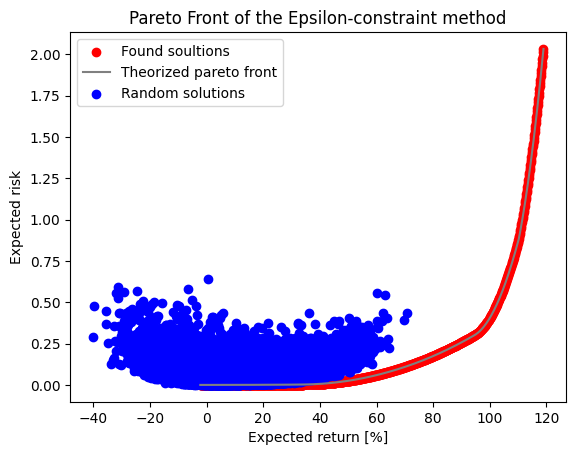

In [66]:
pairs = [(i, j) for i, j in zip(found_returns, found_risk)]
print(len(pairs), len(set(pairs)))
plt.scatter(found_returns, found_risk, color="red", label="Found soultions")
plt.plot(found_returns, found_risk, color="gray", label="Theorized pareto front")
plt.scatter(random_profit, random_risk, color="blue", label="Random solutions")

plt.legend()
plt.title("Pareto Front of the Epsilon-constraint method")
plt.xlabel("Expected return [%]")
plt.ylabel("Expected risk")
plt.show()